In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(tidyverse)
library(ggpubr)
library(phyloseq)
library(pairwiseAdonis)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: vegan

R[write to console]: Loading required package: permute

R[write to console]: Loading required package: lattice

R[write to console]: This is vegan 2.5-7

R[write to console]: Loading required package: cluster



In [60]:
%%R
source("R/theme.R")

In [4]:
%%R
tax_s <- read_tsv("data/metaphlan3.merged.abundance.profile.species.272S.tsv") %>%
        column_to_rownames("clade_name")

metadata <- read_tsv("metadata/samples_metadata_imm_272S.tsv") %>%
    mutate(group=case_when(
        TimePoint == "D0" & Vac_Group=="BioNTech" ~ "Baseline & BioNTech",
        TimePoint == "D0" & Vac_Group=="SinoVac" ~ "Baseline & SinoVac",
        TimePoint == "M1" & Vac_Group=="BioNTech" ~ "One Month & BioNTech",
        TimePoint == "M1" & Vac_Group=="SinoVac" ~ "One Month & SinoVac")) %>%
    data.frame()

metadata$Vac_Group <- factor(metadata$Vac_Group, levels=c("BioNTech", "SinoVac"))
rownames(metadata) <- metadata$sample_id

tax_s_pls <- phyloseq(otu_table(tax_s, taxa_are_rows=TRUE),
                      sample_data(metadata))

Rows: 547 Columns: 273
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr   (1): clade_name
dbl (272): VAC003B-M1_S2, VAC005B-M1_S3, VAC007B-M1_S4, VAC010B-M1_S5, VAC01...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 272 Columns: 57
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (7): sample_id, ID, TimePoint, Cohort, Vac_Group, Dose1_AE_num_cat, Dos...
dbl (50): all_bray_cluster3, Age, Male, BMI, OWOB, Obese_bin, HTC_bin, DMC_b...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
%%R
df = plyr::ldply(plist, function(x) x$data)
names(df)[1] <- "distance"
dim(df)
df <- df %>%
    mutate(group=case_when(
        (Vac_Group=="SinoVac") & (TimePoint=="D0") ~ "D0+SinoVac",
        (Vac_Group=="SinoVac") & (TimePoint=="M1") ~ "M1+SinoVac",
        (Vac_Group=="BioNTech") & (TimePoint=="D0") ~ "D0+BioNTech",
        (Vac_Group=="BioNTech") & (TimePoint=="M1") ~ "M1+BioNTech",
    ))

In [7]:
%%R
set.seed(1991)
iDist <- distance(tax_s_pls, method="jsd")
iNMDS <- ordinate(tax_s_pls, "NMDS", distance=iDist)

Run 0 stress 0.2664496 
Run 1 stress 0.287856 
Run 2 stress 0.2695785 
Run 3 stress 0.2921582 
Run 4 stress 0.2697325 
Run 5 stress 0.2782608 
Run 6 stress 0.2679073 
Run 7 stress 0.2753609 
Run 8 stress 0.2872422 
Run 9 stress 0.2878785 
Run 10 stress 0.2843196 
Run 11 stress 0.2787776 
Run 12 stress 0.279902 
Run 13 stress 0.2740347 
Run 14 stress 0.2677646 
Run 15 stress 0.2877055 
Run 16 stress 0.2667844 
... Procrustes: rmse 0.0183044  max resid 0.1882636 
Run 17 stress 0.268729 
Run 18 stress 0.2832413 
Run 19 stress 0.2766324 
Run 20 stress 0.2754495 
*** No convergence -- monoMDS stopping criteria:
     5: no. of iterations >= maxit
    15: stress ratio > sratmax


In [29]:
%%R
meta_table <- data.frame(phyloseq::sample_data(tax_s_pls))
otu_table <- data.frame(phyloseq::otu_table(tax_s_pls))

In [8]:
%%R
#mod <- vegan::betadisper(iDist, meta_table$group, type="centroid")
mod <- vegan::betadisper(iDist, metadata$group, type="centroid")

In [9]:
%%R
mod


	Homogeneity of multivariate dispersions

Call: vegan::betadisper(d = iDist, group = metadata$group, type =
"centroid")

No. of Positive Eigenvalues: 81
No. of Negative Eigenvalues: 190

Average distance to centroid:
 Baseline & BioNTech   Baseline & SinoVac One Month & BioNTech 
              0.2869               0.2735               0.2974 
 One Month & SinoVac 
              0.2885 

Eigenvalues for PCoA axes:
(Showing 8 of 271 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
4.342 2.946 2.416 1.905 1.748 1.648 1.293 1.260 


In [10]:
%%R
pmod <- vegan::permutest(mod, permutations=99, pairwise=TRUE)

In [11]:
%%R
pmod


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 99

Response: Distances
           Df  Sum Sq   Mean Sq      F N.Perm Pr(>F)
Groups      3 0.01634 0.0054469 1.4536     99   0.24
Residuals 268 1.00421 0.0037471                     

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
                     Baseline & BioNTech Baseline & SinoVac
Baseline & BioNTech                                0.180000
Baseline & SinoVac              0.210683                   
One Month & BioNTech            0.213377           0.040297
One Month & SinoVac             0.889615           0.325658
                     One Month & BioNTech One Month & SinoVac
Baseline & BioNTech              0.210000                0.86
Baseline & SinoVac               0.050000                0.27
One Month & BioNTech                                     0.49
One Month & SinoVac              0.495318                    


In [12]:
%%R
p.values <- pmod$pairwise$observed

In [13]:
%%R
p.values <- p.values[!is.na(p.values<=0.05)]

In [14]:
%%R
p.values

  Baseline & BioNTech-Baseline & SinoVac 
                              0.21068334 
Baseline & BioNTech-One Month & BioNTech 
                              0.21337742 
 Baseline & BioNTech-One Month & SinoVac 
                              0.88961514 
 Baseline & SinoVac-One Month & BioNTech 
                              0.04029706 
  Baseline & SinoVac-One Month & SinoVac 
                              0.32565841 
One Month & BioNTech-One Month & SinoVac 
                              0.49531831 


In [15]:
%%R
signi_label <- paste(cut(p.values, breaks=c(-Inf, 0.001, 0.01, 0.05, Inf),
                        label=c("***", "**", "*", ".")))

In [16]:
%%R
groups_compared <- names(p.values)

In [17]:
%%R
betadisper_res <- data.frame(groups_compared, p.values, signi_label)

In [18]:
%%R
betadisper_res

                                                                  groups_compared
Baseline & BioNTech-Baseline & SinoVac     Baseline & BioNTech-Baseline & SinoVac
Baseline & BioNTech-One Month & BioNTech Baseline & BioNTech-One Month & BioNTech
Baseline & BioNTech-One Month & SinoVac   Baseline & BioNTech-One Month & SinoVac
Baseline & SinoVac-One Month & BioNTech   Baseline & SinoVac-One Month & BioNTech
Baseline & SinoVac-One Month & SinoVac     Baseline & SinoVac-One Month & SinoVac
One Month & BioNTech-One Month & SinoVac One Month & BioNTech-One Month & SinoVac
                                           p.values signi_label
Baseline & BioNTech-Baseline & SinoVac   0.21068334           .
Baseline & BioNTech-One Month & BioNTech 0.21337742           .
Baseline & BioNTech-One Month & SinoVac  0.88961514           .
Baseline & SinoVac-One Month & BioNTech  0.04029706           *
Baseline & SinoVac-One Month & SinoVac   0.32565841           .
One Month & BioNTech-One Month & SinoVac 0

In [19]:
%%R
#adonis_res <- vegan::adonis(iDist ~ group, data=meta_table)
adonis_res <- vegan::adonis(iDist ~ group, data=metadata)

In [20]:
%%R
adonis_res


Call:
vegan::adonis(formula = iDist ~ group, data = metadata) 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs  MeanSqs F.Model     R2 Pr(>F)
group       3    0.2302 0.076741 0.86592 0.0096  0.675
Residuals 268   23.7510 0.088623         0.9904       
Total     271   23.9813                  1.0000       


In [21]:
%%R  ## very strange
#adonis_res_pw <- pairwise.adonis(iDist, factor=meta_table$group)
adonis_res_pw <- pairwise.adonis(iDist, factor=metadata$group)

In [24]:
%%R
length(iDist)

[1] 36856


In [28]:
%%R
272 * 272 / 2 - 272 / 2

[1] 36856


In [22]:
%%R
adonis_res_pw

                                        pairs Df  SumsOfSqs   F.Model
1   Baseline & SinoVac vs One Month & SinoVac  1 0.06602219 0.7730196
2   Baseline & SinoVac vs Baseline & BioNTech  1 0.07328418 0.8671505
3  Baseline & SinoVac vs One Month & BioNTech  1 0.05878752 0.6561641
4  One Month & SinoVac vs Baseline & BioNTech  1 0.12632203 1.4409092
5 One Month & SinoVac vs One Month & BioNTech  1 0.08120685 0.8745108
6 Baseline & BioNTech vs One Month & BioNTech  1 0.05810903 0.6472230
           R2 p.value p.adjusted sig
1 0.010770336   0.691      1.000    
2 0.006335709   0.562      1.000    
3 0.004909344   0.761      1.000    
4 0.010560683   0.149      0.894    
5 0.006581479   0.587      1.000    
6 0.003274638   0.789      1.000    


In [74]:
%%R
summary(adonis_res)

             Length Class  Mode   
aov.tab         6   anova  list   
call            3   -none- call   
coefficients    0   -none- NULL   
coef.sites   1088   -none- numeric
f.perms       999   -none- numeric
model.matrix 1088   -none- numeric
terms           3   terms  call   


In [75]:
%%R
summary(adonis_res_pw)

    pairs                 Df      SumsOfSqs          F.Model      
 Length:6           Min.   :1   Min.   :0.07335   Min.   :0.8657  
 Class :character   1st Qu.:1   1st Qu.:0.11897   1st Qu.:1.3759  
 Mode  :character   Median :1   Median :0.21297   Median :2.5183  
                    Mean   :1   Mean   :0.20413   Mean   :2.3517  
                    3rd Qu.:1   3rd Qu.:0.27426   3rd Qu.:3.1066  
                    Max.   :1   Max.   :0.34319   Max.   :3.9101  
       R2              p.value          p.adjusted         sig           
 Min.   :0.006325   Min.   :0.00100   Min.   :0.0060   Length:6          
 1st Qu.:0.009860   1st Qu.:0.00225   1st Qu.:0.0135   Class :character  
 Median :0.017779   Median :0.01050   Median :0.0630   Mode  :character  
 Mean   :0.018474   Mean   :0.17417   Mean   :0.3563                     
 3rd Qu.:0.025914   3rd Qu.:0.32550   3rd Qu.:0.7725                     
 Max.   :0.033112   Max.   :0.59300   Max.   :1.0000                     


In [76]:
%%R
iDist_df <- iDist %>% as.matrix() %>% as.data.frame() %>% rownames_to_column("sample_id") %>%
    pivot_longer(!sample_id, names_to="sample_id2", values_to="distance")
    
iDist_df_filtered <-
    iDist_df %>%
    rowwise() %>%
    filter(str_split(sample_id, "-|_")[[1]][1] == str_split(sample_id2, "-|_")[[1]][1] &
            str_split(sample_id, "-|_")[[1]][2] != str_split(sample_id2, "-|_")[[1]][2]) %>%
    left_join(metadata) %>% distinct(ID, .keep_all= TRUE)

Joining, by = "sample_id"


In [87]:
%%R
pdata <- phyloseq::plot_ordination(tax_s_pls, iNMDS, color="TimePoint", shape="TimePoint")$data
pdata <- pdata %>%
    mutate(group=case_when(
        Vac_Group=="SinoVac" & TimePoint=="D0" ~ "Baseline & SinoVac",
        Vac_Group=="SinoVac" & TimePoint=="M1" ~ "One Month & SinoVac",
        Vac_Group=="BioNTech" & TimePoint=="D0" ~ "Baseline & BioNTech",
        Vac_Group=="BioNTech" & TimePoint=="M1" ~ "One Month & BioNTech"))

In [88]:
%%R
group_label <- cbind(NMDS1=tapply(pdata$NMDS1, pdata$group, mean),
                    NMDS2=tapply(pdata$NMDS2, pdata$group, mean)) %>%
data.frame() %>% rownames_to_column("group")

In [89]:
%%R
group_label

                 group        NMDS1         NMDS2
1  Baseline & BioNTech  0.002752604  0.0248404260
2   Baseline & SinoVac  0.010316285  0.0003373714
3 One Month & BioNTech -0.007568870 -0.0096343222
4  One Month & SinoVac  0.002278713 -0.0438111718


In [90]:
%%R
stress.value <- iNMDS$stress
stress.label <- paste("STRESS=", round(stress.value, 4))

In [91]:
%%R
adn_pvalue <- adonis_res[[1]][["Pr(>F)"]][1]
adn_rsquared <- round(adonis_res[[1]][["R2"]], 3)
signi_label <- paste(cut(adn_pvalue,
                         breaks=c(-Inf, 0.001, 0.01, 0.05, Inf),
                         label=c("***", "**", "*", ".")))
adn_res_format <- bquote(atop(atop("PERMANOVA", R^2==~.(adn_rsquared)),
                             atop("p-value="~.(adn_pvalue)~.(signi_label),
                                  phantom())))

In [92]:
%%R
adonis_res_pw %>% data.frame() %>% knitr::kable("simple")



pairs                                          Df   SumsOfSqs     F.Model          R2   p.value   p.adjusted  sig 
--------------------------------------------  ---  ----------  ----------  ----------  --------  -----------  ----
One Month & BioNTech vs One Month & SinoVac     1   0.0917303   1.0240675   0.0076984     0.429        1.000      
One Month & BioNTech vs Baseline & SinoVac      1   0.2252373   2.6051591   0.0192114     0.006        0.036  .   
One Month & BioNTech vs Baseline & BioNTech     1   0.2905969   3.2737101   0.0163462     0.001        0.006  *   
One Month & SinoVac vs Baseline & SinoVac       1   0.2007023   2.4314351   0.0331116     0.015        0.090      
One Month & SinoVac vs Baseline & BioNTech      1   0.3431873   3.9101218   0.0281486     0.001        0.006  *   
Baseline & SinoVac vs Baseline & BioNTech       1   0.0733522   0.8656688   0.0063250     0.593        1.000      


In [93]:
%%R
adn_pvalue <- adonis_res[[1]][["Pr(>F)"]][1]
adn_rsquared <- round(adonis_res[[1]][["R2"]], 3)
signi_label <- paste(cut(adn_pvalue,
                         breaks=c(-Inf, 0.001, 0.01, 0.05, Inf),
                         label=c("***", "**", "*", ".")))
adn_res_format <- bquote(atop(atop("PERMANOVA", R^2==~.(adn_rsquared)),
                             atop("p-value="~.(adn_pvalue)~.(signi_label),
                                  phantom())))

## Figure-1b

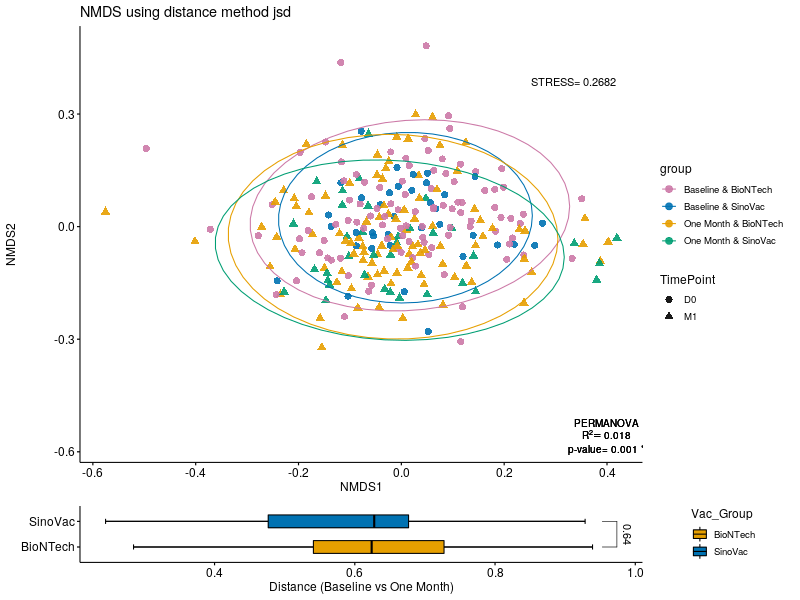

In [69]:
%%R -w 800 -h 600
betap <- ggscatter(pdata, x="NMDS1", y="NMDS2", shape="TimePoint", color="group", fill="group", size=3, alpha=0.9) +
    #geom_point(size=3, alpha=0.5) +
    stat_ellipse(aes(colour=group)) +
    ggtitle(paste("NMDS using distance method ", "jsd", sep="")) +
    scale_fill_manual(values=gt_color_values) +
    scale_color_manual(values=gt_color_values) +
    #geom_text(data=group_label, aes(x=NMDS1, y=NMDS2, label=group, color=group))
    annotate('text', x=max(pdata$NMDS1)*0.8, y=max(pdata$NMDS2)*0.8,
             label=stress.label) +
    annotate('text', x=max(pdata$NMDS1)-0.05*max(pdata$NMDS1),
                     y=min(pdata$NMDS1),
            label=adn_res_format, size=5)
    
betap2 <- ggscatter(pdata, x="NMDS1", y="NMDS2", shape="TimePoint", color="group", fill="group", size=3, alpha=0.9) +
    #geom_point(size=3, alpha=0.5) +
    stat_ellipse(aes(colour=group)) +
    facet_wrap(~Vac_Group) +
    ggtitle(paste("NMDS using distance method ", "jsd", sep="")) +
    scale_fill_manual(values=gt_color_values) +
    scale_color_manual(values=gt_color_values)

distp <- ggboxplot(iDist_df_filtered, x="Vac_Group", y="distance",
          fill="Vac_Group", width = 0.5, outlier.shape = NA, 
          bxp.errorbar = TRUE, bxp.errorbar.width = 0.2) +
        stat_compare_means(comparisons = list(c("BioNTech", "SinoVac")),
                           method = "wilcox.test", p.adjust.method = "fdr",
                           paired=FALSE) +
        ylab("Distance (Baseline vs One Month)") + xlab("") +
        coord_flip() + 
        scale_fill_manual(values=group_color_values)#, guide=FALSE)
    
pp <- ggarrange(betap, distp, nrow = 2, ncol = 1,align = "v", heights = c(5,1), legend = "right")
pp2 <- ggarrange(betap2, distp, nrow = 2, ncol = 1,align = "v", heights = c(5,1), legend = "right")

print(pp)